In this notebook, we will
*  fetch Metadata from Sentinel-1.
*  use the Metadata to download the image(s). 
*  open, calibrate and speckle filter the image and 
* only take out the subsets that we need...

The reason why I preper this chronological order, is that I can use an external dataset to dictate which images to use. 


if you can use it, remember to see the License ;)


# Imports

In [1]:
import sys, os, glob

sys.path.append('../')

In [2]:
from src.s1_python.metadata import Sentinel_metadata
from src.s1_python.download import Satellite_download
from src.s1_python.pre_process_grd._load_image import s1_load
from src.s1_python.visualize import show_cross_pol_function, show_thumbnail_function

In [1]:
from sentinel_1_python.metadata import Sentinel_metadata
from sentinel_1_python.visualize import show_cross_pol_function
from sentinel_1_python.download import Satellite_download
from sentinel_1_python.pre_process_grd import s1_load
import os, glob

## Metadata 

In [3]:
met =  Sentinel_metadata()

In [4]:
lon, lat = 63.877629, -52.358541
met.area([lat-0.01,lat+0.01,lon-0.01,lon+0.01])
met.get_metadata(sensor='s1_grd',start_data='20221001',end_date='20221010')

../src/s1_python/metadata/_utilities.py:35: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  lon = df.geometry.to_crs(4326).centroid.x.values
../src/s1_python/metadata/_utilities.py:36: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  lat = df.geometry.to_crs(4326).centroid.y.values


In [5]:
met.iw() #filer so we only have IW

In [20]:
hh = met.products_df[met.products_df.polarisationmode.isin(["HH HV"])]

In [12]:
import geopandas as gpd
import matplotlib.pyplot as plt

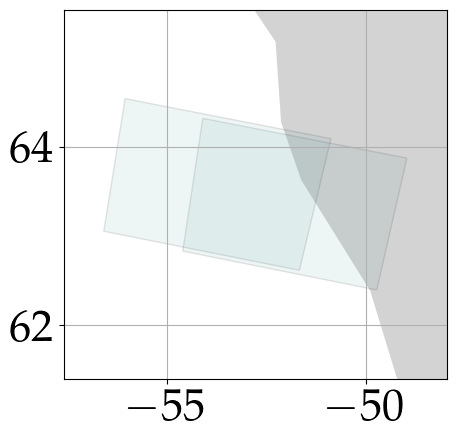

In [17]:
for i in [1]:
    minx, miny, maxx, maxy = met.products_df.geometry.total_bounds
    df_world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
    f, ax = plt.subplots()
    df_world.plot(ax=ax, color="lightgrey")
    met.products_df.plot(ax=ax, color='cadetblue',alpha=0.1, edgecolor='k')
    ax.set_xlim(minx - 1, maxx + 1) # added/substracted value is to give some margin around total bounds
    ax.set_ylim(miny - 1, maxy + 1)
    ax.grid('on', which='minor', axis='x' )
    ax.grid('on', which='major', axis='x' )
    ax.grid('on', which='minor', axis='y' )
    ax.grid('on', which='major', axis='y')

    plt.show()

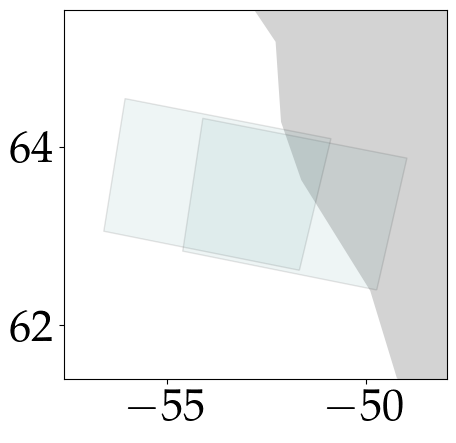

In [7]:

met.plot_image_areas() # Showing extent of images

In [5]:
print(met.products_df.mgcs.unique()[5])
df_mgrs= met.products_df[met.products_df.mgcs==met.products_df.mgcs.unique()[5]]

35VNE


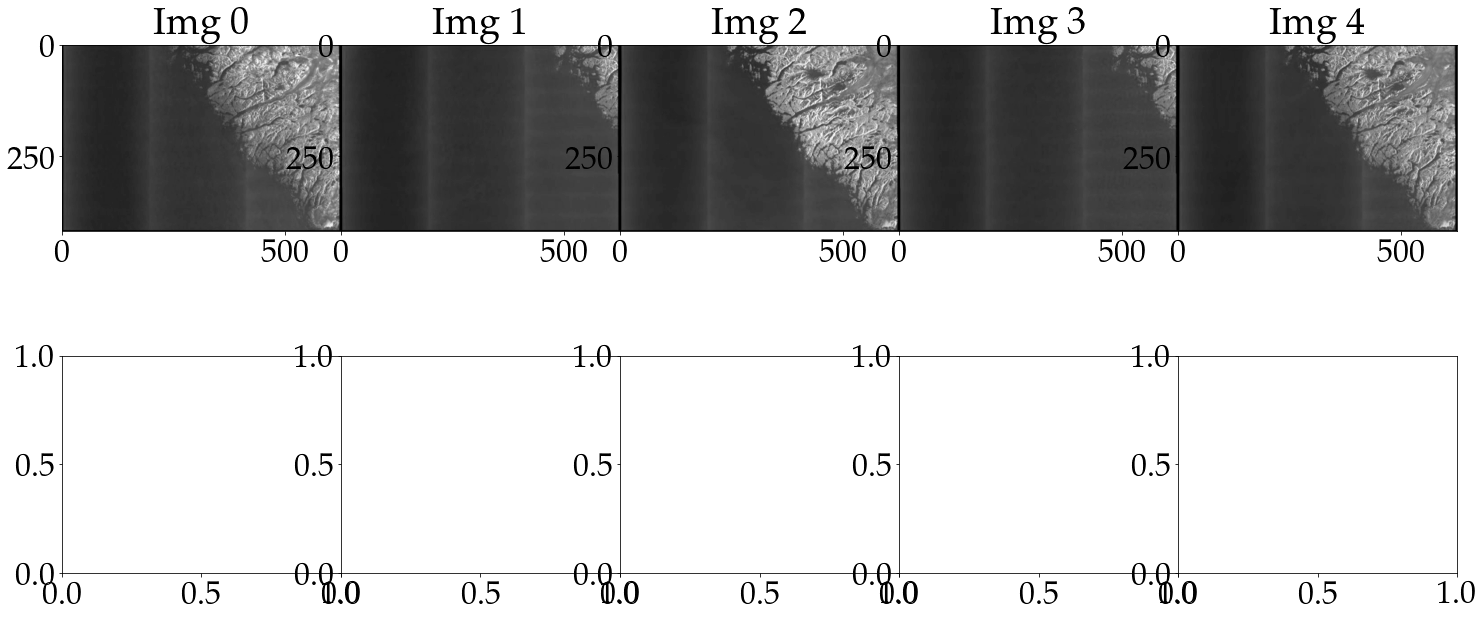

In [21]:
show_cross_pol_function(hh,5,username=os.getenv('COPERNICUS_HUP_USERNAME'),password=os.getenv('COPERNICUS_HUP_PASSWORD'))

## Download 

In [22]:
folder = f'/Users/kaaso/Documents/phd/data/HH_nuuk'
with Satellite_download(hh[0:5]) as dwl:
    os.makedirs(folder, exist_ok=True)
    #save metadata
    dwl.products_df.to_pickle(f'{folder}/grd_dataframe.pkl')
    #download the thumbnails
    dwl.download_thumbnails(folder=f'{folder}/grd_thumbnails') 
    #download the entire image (grd) for some.. 
    dwl.download_sentinel_1(f'{folder}/grd')


 > Command line argument '--ip=127.0.0.1' makes no sense, ignoring.
 > Command line argument '--stdin=9003' makes no sense, ignoring.
 > Command line argument '--control=9001' makes no sense, ignoring.
 > Command line argument '--hb=9000' makes no sense, ignoring.
 > Command line argument '--Session.signature_scheme="hmac-sha256"' makes no sense, ignoring.
 > Command line argument '--Session.key=b"dd909dec-6923-473d-a586-2dfbb881f1f4"' makes no sense, ignoring.
 > Command line argument '--shell=9002' makes no sense, ignoring.
 > Command line argument '--transport="tcp"' makes no sense, ignoring.
 > Command line argument '--iopub=9004' makes no sense, ignoring.
 > Command line argument '--f=/Users/kaaso/Library/Jupyter/runtime/kernel-v2-3999njusQXvNLCHB.json' makes no sense, ignoring.
 > attempting to download https://urs.earthdata.nasa.gov/profile
 > Reusing previous cookie jar.
 > 'Temporary' Redirect download @ Remote archive:
 > https://dy4owt9f80bz7.cloudfront.net/s3-06b3213905ebfa

## Load and calibrate

In [4]:
image_paths = glob.glob(f'{os.getenv("raw_data_dir")}/*/*/*.SAFE')
image_paths

['../../data/raw/sweden_data/grd/S1A_IW_GRDH_1SDV_20221008T045943_20221008T050008_045346_056BF3_0954.SAFE']

### Load Image

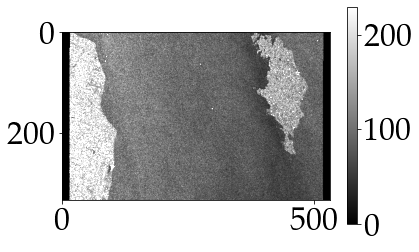

In [5]:
img = s1_load(image_paths[0])
img.simple_plot(band_index=0,stride=50)

### Radiometric calibration (really just dependant on incidence angle. Here gamma)

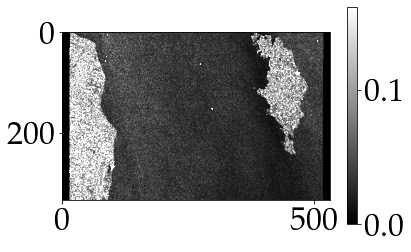

In [10]:
img =img.calibrate(mode='gamma') # could also use, e.g., 'sigma_0' 
img.simple_plot(band_index=0,stride=50)

It takes 130 seconds on my laptop to calibrate the entire image. 

### Speckle filtering.  Here the simplest, i.e., box filter

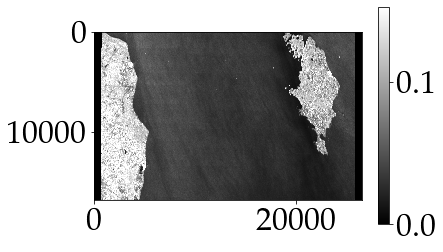

In [11]:
img = img.boxcar(5) #could easily make, e.g., a Lee filter..
img.simple_plot(band_index=0)

It takes 35 seconds on my laptop to perform box filerting on the entire image.

In [126]:
#import matplotlib.pyplot as plt
#diff = img.bands[1]-img_box.bands[1]
#plt.imshow(diff[::10,::10],cmap='gray',vmin=-0.001,vmax=0.001)
#plt.colorbar()

### Taking a subset

Now, lets say we know the position of, e.g., a ship (or another object) we might want to take that subset out:

In [12]:
indx = img.get_index(lat=57.0047,long=19.399)
print('index: ',indx)
#checking accuracy
print('coord: ',img.get_coordinate(indx[0],indx[1]))

index:  (9902, 15705)
coord:  (57.00469210530435, 19.39895965014322)


vh


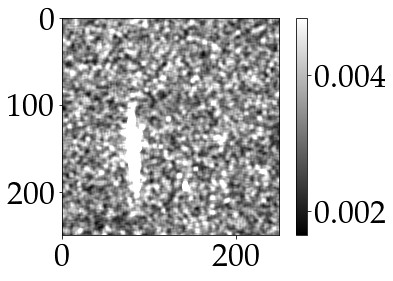

In [13]:
print('vh')
img[indx[0]-125:indx[0]+125,indx[1]-125:indx[1]+125].simple_plot(band_index=1)

vv


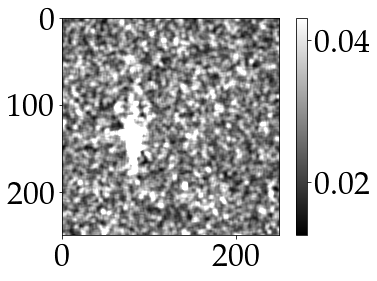

In [14]:
print('vv')
img[indx[0]-125:indx[0]+125,indx[1]-125:indx[1]+125].simple_plot(band_index=0)


In [15]:
subset = img[indx[0]-125:indx[0]+125,indx[1]-125:indx[1]+125]

In [16]:
subset

Mission: SENTINEL-1A 
 Bands: ['VV', 'VH']

In [17]:
subset.band_meta

[{'missionId': 'S1A',
  'productType': 'GRD',
  'polarisation': 'VV',
  'mode': 'IW',
  'swath': 'IW',
  'startTime': '2022-10-08T04:59:43.818129',
  'stopTime': '2022-10-08T05:00:08.816946',
  'absoluteOrbitNumber': '45346',
  'missionDataTakeId': '355315',
  'imageNumber': '001'},
 {'missionId': 'S1A',
  'productType': 'GRD',
  'polarisation': 'VH',
  'mode': 'IW',
  'swath': 'IW',
  'startTime': '2022-10-08T04:59:43.818129',
  'stopTime': '2022-10-08T05:00:08.816946',
  'absoluteOrbitNumber': '45346',
  'missionDataTakeId': '355315',
  'imageNumber': '002'}]

In [18]:
print(img.unit)

gamma
